# 9월 3일 소음예측 AI
<br>

참고자료 

- 삼성전자 주식, 이더리움 시세 인공지능으로 예측해보자 - Python, Deep Learning<br>
https://youtu.be/sG_WeGbZ9A4
- 온도 데이터, 시계열 예측하기<br>
https://ahnjg.tistory.com/33 
- LSTM 순환 신경망으로 코스피 지수 회귀 모델링<br>
https://jonghyunho.github.io/data/analysis/LSTM-%EC%88%9C%ED%99%98-%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9C%BC%EB%A1%9C-%EC%BD%94%EC%8A%A4%ED%94%BC-%EC%A7%80%EC%88%98-%ED%9A%8C%EA%B7%80-%EB%AA%A8%EB%8D%B8%EB%A7%81.html
- Heart sounds analysis and classification with LSTM<br>
https://www.kaggle.com/mychen76/heart-sounds-analysis-and-classification-with-lstm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.models import load_model
import datetime
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment
from scipy.signal import resample
import IPython.display as ipd

In [2]:
uploaded_file_name = 'test.wav'
EXPECTED_SAMPLE_RATE = 44100 #44.1KHz

def convert_audio_for_model(user_file, output_file = 'converted_audio_file.wav'):
    audio = AudioSegment.from_file(user_file, format = "wav")
    audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
    audio.export(output_file, format="wav")
    return output_file

converted_audio_file = convert_audio_for_model(uploaded_file_name)

ipd.Audio(converted_audio_file)

In [3]:
# Loading audio samples from the wav file : 
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# 오디오 정보 출력
duration = len(audio_samples)/sample_rate
print("data :", audio_samples)
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

data : [ 1025  3071  5121 ... -5628 -3588 -1534]
Sample rate: 44100 Hz
Total duration: 5.75s
Size of the input: 253440


No handles with labels found to put in legend.


count    253440.000000
mean          0.022727
std       13317.174470
min      -22273.000000
25%      -11454.500000
50%         127.000000
75%       11585.000000
max       22271.000000
Name: 0, dtype: float64


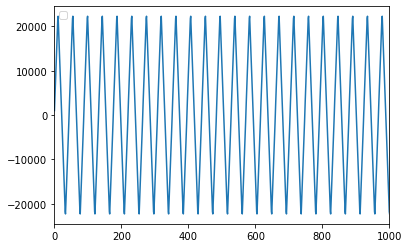

,Unnamed: 0,0
0,0,1025
1,1,3071
2,2,5121
3,3,7168
4,4,9215
...,...,...
253435,253435,-9724
253436,253436,-7684
253437,253437,-5628
253438,253438,-3588


In [4]:
# csv파일 불러오기
pd.DataFrame(audio_samples).to_csv("test.csv")
data = pd.read_csv('test.csv')
# train_data = data['0'].values/1000

# data 정보 출력
print(data['0'].describe())
# train data 그래프 출력
plt.plot(data['0'])
plt.xlim(0,1000)
plt.legend()
plt.show()
data

In [5]:
X = np.arange(len(data)).reshape(-1,1)
y = data['0'].values
y = y.reshape(-1,1)
print("X : \n", X)
print("\ny : \n", y)

X : 
 [[     0]
 [     1]
 [     2]
 ...
 [253437]
 [253438]
 [253439]]

y : 
 [[ 1025]
 [ 3071]
 [ 5121]
 ...
 [-5628]
 [-3588]
 [-1534]]


In [6]:
# 딥러닝 학습을 정상적으로 동작 시키기 위해 데이터 정규화
y_std = y.std()
y_mean = y.mean()
y = (y-y_mean) / y_std
y

array([[ 0.07696672],
       [ 0.23060322],
       [ 0.38454008],
       ...,
       [-0.42261471],
       [-0.26942876],
       [-0.11519153]])

In [7]:
seq_len = 50   #window size : 예측을 위한 데이터 수
prediction = 1  # 다음을 예측할 데이터 수
sequence_length = seq_len + prediction

result = []
for index in range(len(y) - sequence_length):
    result.append(y[index: index + sequence_length])

result

[array([[ 0.07696672],
        [ 0.23060322],
        [ 0.38454008],
        [ 0.53825167],
        [ 0.69196326],
        [ 0.86512346],
        [ 1.01875995],
        [ 1.17262172],
        [ 1.32655859],
        [ 1.47996981],
        [ 1.63413194],
        [ 1.67235334],
        [ 1.49949351],
        [ 1.34555665],
        [ 1.19192015],
        [ 1.03798329],
        [ 0.88434679],
        [ 0.73040993],
        [ 0.57677343],
        [ 0.40368833],
        [ 0.24982656],
        [ 0.09626515],
        [-0.05789698],
        [-0.21123312],
        [-0.36539525],
        [-0.5381049 ],
        [-0.69226704],
        [-0.84560317],
        [-0.9997653 ],
        [-1.15325162],
        [-1.30733866],
        [-1.46090007],
        [-1.63398517],
        [-1.67250694],
        [-1.51849498],
        [-1.36493358],
        [-1.2111469 ],
        [-1.05713494],
        [-0.90372372],
        [-0.73018807],
        [-0.57700212],
        [-0.42261471],
        [-0.26942876],
        [-0

In [8]:
result = np.array(result)
row = int(round(result.shape[0] * 0.7))
train = result[:row, :]

In [9]:
# 현재를 기준으로 최근 50개 데이터를 시험에 사용하고 그 외의 이전 데이터들은 학습에 사용
test_period = 50

X_train = train[:, :-prediction]
y_train = train[:,-prediction]
X_test = result[row:, :-prediction]
y_test = result[row:, -prediction]

print("shape of X_train : ", X_train.shape)
print("shape of y_train : ", y_train.shape)
print("shape of X_test : ", X_test.shape)
print("shape of y_test : ", y_test.shape)

shape of X_train :  (177372, 50, 1)
shape of y_train :  (177372, 1)
shape of X_test :  (76017, 50, 1)
shape of y_test :  (76017, 1)


In [10]:
# 학습데이터 : 검증데이터 = 7 : 3  (학습이 진행되는 중에도 학습이 정상적으로 이루어지는지 확인하기 위함)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [11]:
# tensorflow에 데이터를 전달하기 전에 입력 형식을 맞추기 위해 2차원 데이터를 3차원 데이터로 변환
X = X.reshape(X.shape[0], X.shape[1], 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("shape of X : ", X.shape)  # data 수 
print("shape of X_train : ", X_train.shape)  # (data 수 - test_period)의 70%
print("shape of X_val : ", X_val.shape)  # (data 수 - test_period)의 30%
print("shape of X_test : ", X_test.shape)  # test_period

shape of X :  (253440, 1, 1)
shape of X_train :  (124160, 50, 1)
shape of X_val :  (53212, 50, 1)
shape of X_test :  (76017, 50, 1)


In [12]:
# 모델 생성
print('Build LSTM RNN model ...')
model = Sequential()

# LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))  # (timestep, feature)
model.add(LSTM(64, return_sequences=False))

# Output(Dense) : 1개 
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Build LSTM RNN model ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [13]:
%%time 
# 트레이닝 값으로 학습
print ("training started..... please wait.")
hist = model.fit(X_train, y_train, epochs = 5, batch_size=10, validation_data=(X_val, y_val))

# 모델 저장
model.save('weight.h5')
print ("training finised!")

training started..... please wait.
Epoch 1/5
12416/12416 [==============================] - 293s 23ms/step - loss: 0.0061 - val_loss: 3.6354e-04
Epoch 2/5
12416/12416 [==============================] - 302s 24ms/step - loss: 1.7278e-04 - val_loss: 3.8664e-05
Epoch 3/5
12416/12416 [==============================] - 282s 23ms/step - loss: 9.7300e-05 - val_loss: 1.8660e-04
Epoch 4/5
12416/12416 [==============================] - 299s 24ms/step - loss: 7.1437e-05 - val_loss: 1.7565e-05
Epoch 5/5
12416/12416 [==============================] - 251s 20ms/step - loss: 5.6819e-05 - val_loss: 3.8163e-06
training finised!
Wall time: 23min 46s


<function matplotlib.pyplot.show(close=None, block=None)>

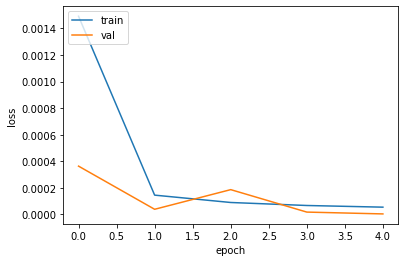

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show

In [15]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
valScore = model.evaluate(X_val, y_val, verbose=0)
testScore = model.evaluate(X_test, y_test, verbose=0)

print('Train Score : ', trainScore)
print('Validation Score : ', valScore)
print('Test Score : ', testScore)

Train Score :  3.861992354359245e-06
Validation Score :  3.816322077909717e-06
Test Score :  3.847761036013253e-06


In [16]:
pred = model.predict(X_test)  # 모델을 사용하여 예측한다

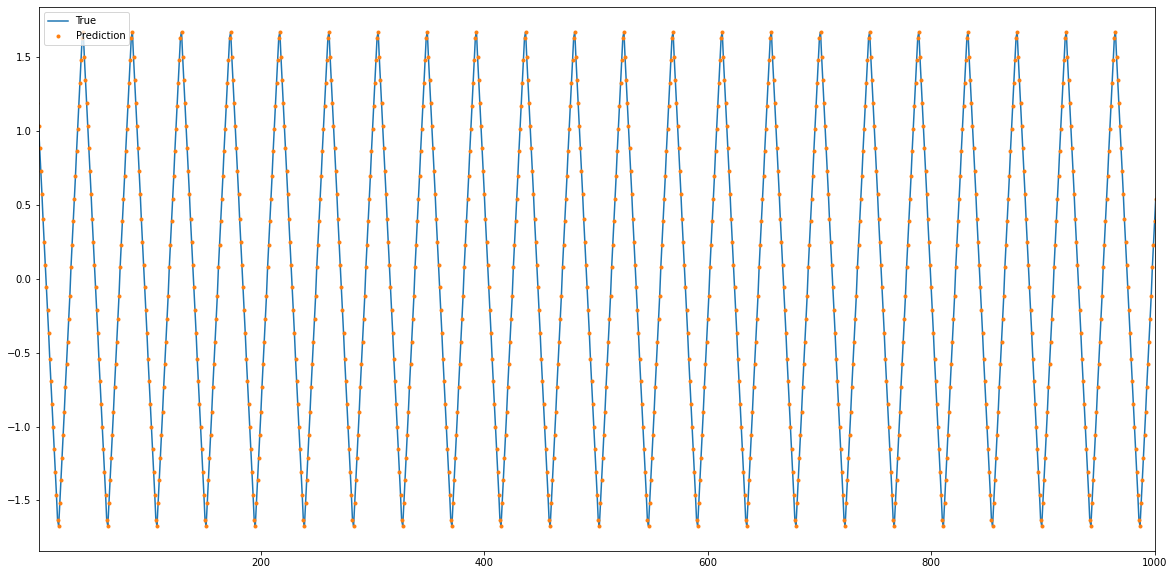

In [17]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, '.', label='Prediction')
ax.legend()
plt.xlim(1,1000)
plt.show()

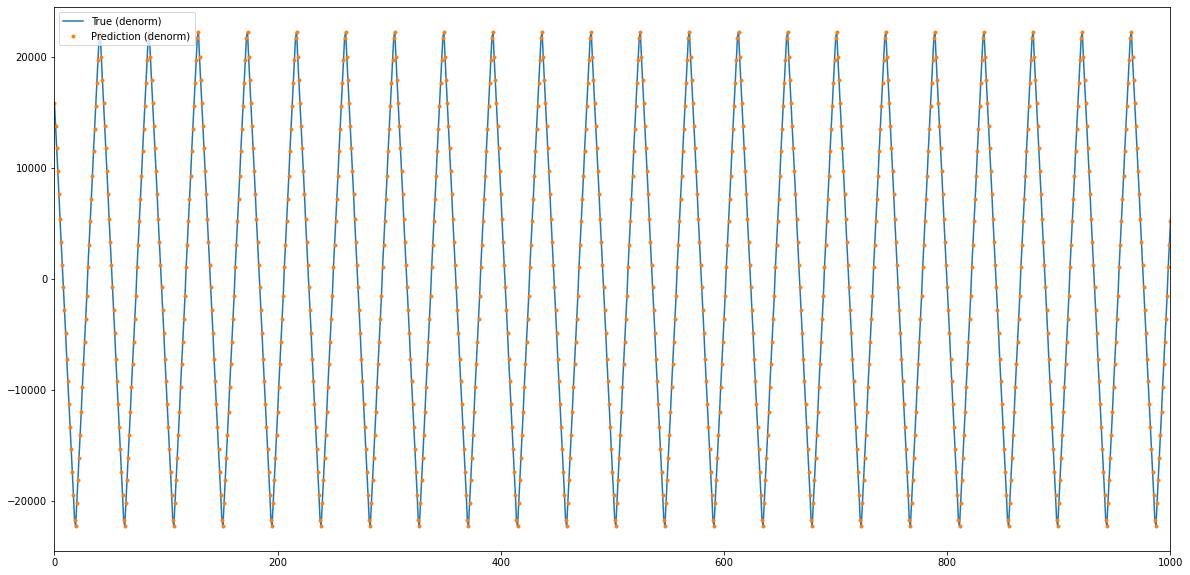

In [18]:
# 정규화된 데이터를 복원하기 위해 사용하는 함수
def denorm(y):
    return y * y_std + y_mean

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(denorm(y_test), label='True (denorm)')
ax.plot(denorm(pred), '.', label='Prediction (denorm)')
ax.legend()
plt.xlim(0,1000)
plt.show()

In [19]:
wavfile.write("pred.wav", EXPECTED_SAMPLE_RATE, pred)

In [20]:
ipd.Audio("pred.wav")

In [21]:
denorm(pred).shape

(76017, 1)